<a href="https://colab.research.google.com/github/javahedi/SemanticFilter/blob/main/nlp_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import torch
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer
import numpy as np

In [77]:

# Initialize resources
nltk.download("stopwords")
nlp        = spacy.load("en_core_web_sm")
stemmer    = PorterStemmer()
stop_words = set(stopwords.words("english"))
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


cpu


In [78]:
# Load sentence transformer models with device specification
models = [
    SentenceTransformer("all-MiniLM-L6-v2", device=device),
    #SentenceTransformer("all-mpnet-base-v2", device=device),
    #SentenceTransformer("multi-qa-mpnet-base-cos-v1", device=device)
]


In [79]:
# Keywords for filtering and classification
virology_keywords     = ["virus", "virology", "viral", "infection", "pathogen"]
epidemiology_keywords = ["epidemiology", "outbreak", "spread", "public health", "disease"]
filtering_keywords    = virology_keywords + epidemiology_keywords

text_mining_keywords  = [
    "natural language processing", "text mining", "nlp", "computational linguistics",
    "language processing", "text data analytics", "textual data", "speech and language technology",
    "language modeling", "computational semantics", "grnn", "rnn", "lstm", "llm"
]

computer_vision_keywords  = [
    "computer vision", "image processing", "object recognition", "scene understanding",
    "vision model", "convolutional neural network", "cnn", "deep learning", "transformer"
]



In [80]:
## Define functions

def fill_na(data, columns=['Title', 'Abstract']):
    """Fills NaN values in specified columns with empty strings."""
    for col in columns:
        data[col] = data[col].fillna(" ")
    return data

def merge_columns(data, new_column='text', columns_to_merge=['Title', 'Abstract']):
    """Merges specified columns into a single text column."""
    data[new_column] = data[columns_to_merge[0]] + ". " + data[columns_to_merge[1]]
    return data

def remove_special_characters(text):
    return re.sub(r'[^.a-z\s]', '', text.lower())

def tokenize_and_remove_stopwords(text, stop_words):
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

def apply_stemming(tokens, stemmer):
    return [stemmer.stem(word) for word in tokens]

def apply_lemmatization(tokens, nlp):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

def preprocess_text(text, nlp, stemmer, stop_words):
    text   = remove_special_characters(text)
    tokens = tokenize_and_remove_stopwords(text, stop_words)
    tokens = apply_stemming(tokens, stemmer)
    lemmatized = apply_lemmatization(tokens, nlp)
    return " ".join(lemmatized)



def load_and_prepare_data(file_path, columns=['Title', 'Abstract'], new_column='text'):
    """Loads data from a CSV file."""
    data = pd.read_csv(file_path, usecols=columns, encoding='utf-8', nrows=1000)
    data = fill_na(data, columns)
    data = merge_columns(data, new_column, columns_to_merge=['Title', 'Abstract'])
    data[new_column] = data[new_column].apply(lambda x: preprocess_text(x , nlp, stemmer, stop_words) if isinstance(x, str) else "")
    return data


def polishing(texts):
    """Cleans up and splits text into sentences."""
    texts = re.findall(r'[^.]+\. ?', texts)
    texts = [text.strip() for text in texts]
    texts = [' '.join([word for word in text.split() if len(word) > 1]) for text in texts]
    return [text for text in texts if text != ""]


def calculate_similarity(model, query, text):
    query_embedding = model.encode(query, normalize_embeddings=True, device=device)
    text_embeddings = model.encode(text,  normalize_embeddings=True, device=device)
    similarity      = model.similarity(query_embedding, text_embeddings)
    return similarity.detach().cpu().numpy() if hasattr(similarity, 'detach') else np.array(similarity)


def filtering_threshold(similarity_matrix, percentage_elements, percentage_max_value):
    max_value             = np.max(similarity_matrix)
    threshold             = (percentage_max_value / 100) * max_value
    count_above_threshold = np.sum(similarity_matrix >= threshold)
    required_count        = (percentage_elements / 100) * similarity_matrix.size
    return count_above_threshold >= required_count



def filtering(text, models, query, percentage_elements=5, percentage_max_value=70):

    sentences  = polishing(text)


    if len(models) == 1:
        similarity_matrix = calculate_similarity(models[0], query, sentences)
        return filtering_threshold(similarity_matrix, percentage_elements, percentage_max_value)


    results = [
        filtering_threshold(calculate_similarity(model, query, sentences), percentage_elements, percentage_max_value)
        for model in models
    ]

    # Return True if at least two models exceed the threshold
    return results.count(True) >= 2




def calculate_avg_similarity(text, model, query_text_mining, query_computer_vision):

    # Calculate similarity for both query sets
    similarity_text_mining     = calculate_similarity(model, query_text_mining, text)
    similarity_computer_vision = calculate_similarity(model, query_computer_vision, text)

    # Calculate average similarity
    avg_similarity_text_mining     = np.mean(similarity_text_mining)
    avg_similarity_computer_vision = np.mean(similarity_computer_vision)

    return avg_similarity_text_mining, avg_similarity_computer_vision



def add_similarity_columns(data, model, query_text_mining, query_computer_vision):
    data[['avg_similarity_text_mining', 'avg_similarity_computer_vision']] = \
        data['processed_text'].apply(lambda x: pd.Series(calculate_avg_similarity(x, model, query_text_mining, query_computer_vision)))
    return data



def extract_statistics(df, columns_name):


    statistics_summary = df[columns_name].describe()
    stats = {}
    for column in columns_name:
        stats[column] = {
            'mean': statistics_summary.loc['mean', column],
            'std': statistics_summary.loc['std', column],
            '25%': statistics_summary.loc['25%', column],
            '75%': statistics_summary.loc['75%', column]
        }

    return stats



def assign_method_labels1(data):


    stats = extract_statistics(data, ['avg_similarity_text_mining', 'avg_similarity_computer_vision'])

    text_mining_75th     = stats['avg_similarity_text_mining']['75%']
    computer_vision_75th = stats['avg_similarity_computer_vision']['75%']
    text_mining_mean     = stats['avg_similarity_text_mining']['mean']
    computer_vision_mean = stats['avg_similarity_computer_vision']['mean']
    both_50th            = (text_mining_mean + computer_vision_mean) / 2 #0.1
    text_mining_25th     = stats['avg_similarity_text_mining']['25%']
    computer_vision_25th = stats['avg_similarity_computer_vision']['25%']
    tolerance            = both_50th/10#0.02

    labels = []
    for _, row in data.iterrows():
        text_mining_sim     = row['avg_similarity_text_mining']
        computer_vision_sim = row['avg_similarity_computer_vision']


        if text_mining_sim > text_mining_75th and text_mining_sim > computer_vision_sim:
            labels.append('text mining')


        elif computer_vision_sim > computer_vision_75th and computer_vision_sim > text_mining_sim:
            labels.append('computer vision')


        elif (
            text_mining_sim > both_50th and computer_vision_sim > both_50th and
            abs(text_mining_sim - computer_vision_sim) < tolerance
        ):
            labels.append('both')


        elif text_mining_sim < text_mining_25th and computer_vision_sim < computer_vision_25th:
            labels.append('other')


        else:
            if text_mining_sim > computer_vision_sim:
                labels.append('text mining')
            else:
                labels.append('computer vision')

    data['method1'] = labels
    return data


def assign_method_labels2(data):

    stats = extract_statistics(data, ['avg_similarity_text_mining', 'avg_similarity_computer_vision'])
    text_mining_mean     = stats['avg_similarity_text_mining']['mean']
    text_mining_std      = stats['avg_similarity_text_mining']['std']
    computer_vision_mean = stats['avg_similarity_computer_vision']['mean']
    computer_vision_std  = stats['avg_similarity_computer_vision']['std']


    labels = []
    for _, row in data.iterrows():
        text_mining_sim     = row['avg_similarity_text_mining']
        computer_vision_sim = row['avg_similarity_computer_vision']


        if text_mining_sim > text_mining_mean + text_mining_std and text_mining_sim > computer_vision_sim:
            labels.append('text mining')


        elif computer_vision_sim > computer_vision_mean + computer_vision_std and computer_vision_sim > text_mining_sim:
            labels.append('computer vision')


        elif (
            text_mining_mean - text_mining_std <= text_mining_sim <= text_mining_mean + text_mining_std and
            computer_vision_mean - computer_vision_std <= computer_vision_sim <= computer_vision_mean + computer_vision_std
        ):
            labels.append('both')


        elif text_mining_sim < 0 and computer_vision_sim < 0:
            labels.append('other')


        else:
            if text_mining_sim > computer_vision_sim:
                labels.append('text mining')
            else:
                labels.append('computer vision')

    data['method2'] = labels
    return data





In [81]:
def plot_filtered_data(data):
    #Count the number of abstracts in each cluster
    filter_counts = data['filtered'].value_counts()

    # Plot
    plt.figure(figsize=(6, 3))
    sns.barplot(x=filter_counts.index,
                y=filter_counts.values,
                hue=filter_counts.index,
                dodge=False, palette="viridis")
    plt.xlabel("Filtering")
    plt.ylabel("Number of Abstracts")
    plt.title("Number of Abstracts after filtering")
    plt.show()


def plot_statisics(data):

    # Plot histograms for each similarity measure
    plt.figure(figsize=(8, 2.5))

    # Histogram for Text Mining similarity
    plt.subplot(1, 2, 1)
    sns.histplot(data['avg_similarity_text_mining'], bins=20, kde=True)
    plt.title('Distribution of Avg Similarity - Text Mining')
    plt.xlabel('Avg Similarity Score')
    plt.ylabel('Frequency')

    # Histogram for Computer Vision similarity
    plt.subplot(1, 2, 2)
    sns.histplot(data['avg_similarity_computer_vision'], bins=20, kde=True)
    plt.title('Distribution of Avg Similarity - Computer Vision')
    plt.xlabel('Avg Similarity Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Scatter plot to show correlation
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x='avg_similarity_text_mining', y='avg_similarity_computer_vision', data=data, alpha=0.6)
    plt.title('Scatter Plot of Text Mining vs. Computer Vision Similarity')
    plt.xlabel('Avg Similarity - Text Mining')
    plt.ylabel('Avg Similarity - Computer Vision')
    plt.show()


def plot_class_methods(data, method):
    # Count the number of abstracts in each cluster
    method_counts = data[method].value_counts()

    # Plot
    plt.figure(figsize=(5,3))
    sns.barplot(x=method_counts.index,
                y=method_counts.values,
                hue=method_counts.index,
                dodge=False, palette="viridis")

    plt.xlabel(f"{method}")
    plt.ylabel("Number of Abstracts")
    plt.title("Methods classification")
    plt.show()

In [82]:
def main(file_path):
    newColumn = 'processed_text'
    # Step 1: Load and prepare data
    data = load_and_prepare_data(file_path, columns=['Title', 'Abstract'], new_column=newColumn)

    # Step 2: Filter relevant texts
    query_filtering  = [preprocess_text(term, nlp, stemmer, stop_words) for term in filtering_keywords]
    data['filtered'] = data[newColumn].apply(lambda x: filtering(x, models, query=query_filtering))


    plot_filtered_data(data)

    # Step 3:
    query_text_mining     = [preprocess_text(term, nlp, stemmer, stop_words) for term in text_mining_keywords]
    query_computer_vision = [preprocess_text(term, nlp, stemmer, stop_words) for term in computer_vision_keywords]

    data = add_similarity_columns(data[data['filtered'] == True],models[0],
                                    query_text_mining,query_computer_vision)

    # Calculate basic descriptive statistics
    statistics_summary = data[['avg_similarity_text_mining', 'avg_similarity_computer_vision']].describe()
    print("Basic Descriptive Statistics:")
    print(statistics_summary)

    correlation = data['avg_similarity_text_mining'].corr(data['avg_similarity_computer_vision'])
    print("\nCorrelation between Text Mining and Computer Vision similarity:")
    print(correlation)

    data = assign_method_labels1(data)
    data = assign_method_labels2(data)

    return data

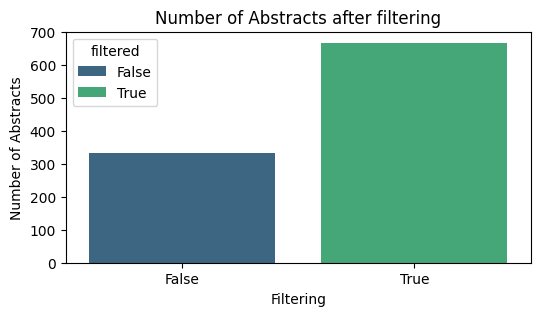

       avg_similarity_text_mining  avg_similarity_computer_vision
count                  667.000000                      667.000000
mean                     0.086272                        0.109210
std                      0.044970                        0.068402
min                     -0.021287                       -0.039725
25%                      0.052680                        0.056126
50%                      0.087160                        0.107134
75%                      0.118675                        0.155970
max                      0.218618                        0.294084
Correlation between Text Mining and Computer Vision similarity: 0.7912520849130991
CPU times: user 12min 35s, sys: 2.4 s, total: 12min 37s
Wall time: 12min 56s


In [83]:
#%%
file_path = "https://raw.githubusercontent.com/jd-coderepos/virology-ai-papers/main/collection_with_abstracts.csv"
%time data = main(file_path)


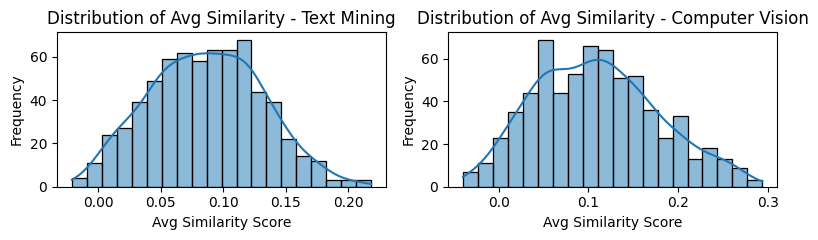

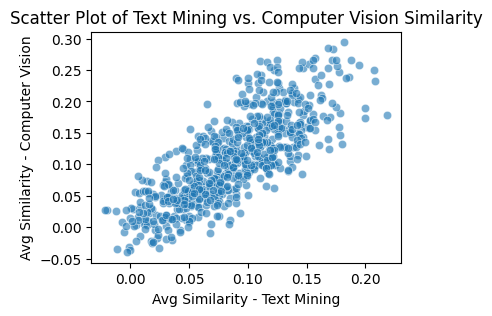

In [84]:
plot_statisics(data)

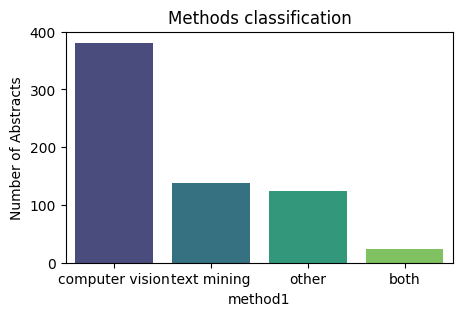

In [85]:
plot_class_methods(data, 'method1')

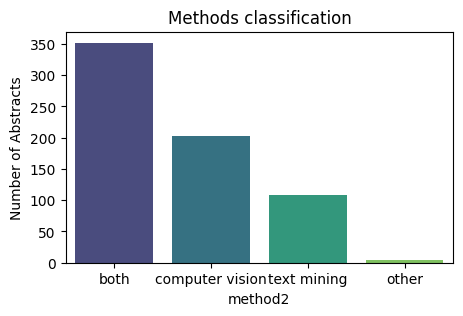

In [86]:
plot_class_methods(data, 'method2')